In [1]:
import numpy as np
np.random.seed(271828)
from os import system, environ
from pickle import dump, load, HIGHEST_PROTOCOL
import pandas as pd
from pprint import pprint
from glob import glob
import datetime as dt
from iminuit import Minuit
from iminuit.cost import LeastSquares
import warnings
from scipy import stats

%matplotlib widget
# %matplotlib inline
# %matplotlib inline
from ipywidgets import *

from plottools import *
import matplotlib.pyplot as plt
import matplotlib
from mplhep import histplot, style
style.use(style.LHCb2)
import matplotlib.dates as mdates
import matplotlib.patheffects as pe
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import *
matplotlib.colormaps.register(name="beer", cmap=LinearSegmentedColormap.from_list("beer", colors=[niceColour('beeryellow'), niceColour('beerbrown')]))
import seaborn as sns

# import plotly.graph_objects as go
# from plotly.offline import iplot
# import plotly.io as pio
# pio.renderers.default='notebook'

import matplotlib.dates as mdates
import matplotlib.patheffects as pe
from matplotlib.ticker import *
warnings.filterwarnings("ignore", message='UserWarning: This figure includes Axes that are not compatible with tight_layout*')

# patch to adjust code for margins in 3D projections
###patch start###
from mpl_toolkits.mplot3d.axis3d import Axis
if not hasattr(Axis, "_get_coord_info_old"):
    def _get_coord_info_new(self, renderer):
        mins, maxs, centers, deltas, tc, highs = self._get_coord_info_old(renderer)
        mins += deltas / 4
        maxs -= deltas / 4
        return mins, maxs, centers, deltas, tc, highs
    Axis._get_coord_info_old = Axis._get_coord_info  
    Axis._get_coord_info = _get_coord_info_new
###patch end###

In [2]:
# df = pd.read_csv("1202beers.csv", delimiter=';', encoding='utf-8')
# df = pd.read_csv("1230beers.csv", delimiter=',', encoding='utf-8')
# df = pd.read_csv("1407beers.csv", delimiter=';', encoding='utf-8')
df = pd.read_csv("1476beers.csv", delimiter=';', encoding='utf-8')

In [70]:
###############################################################################
# Group by storage, which (somewhat) approximates countries of origin
###############################################################################
class Storage:
    def __init__(self, name: str, capacity: int, description: str, colour):
        self.name = name # identifier in the collection
        self.capacity = capacity # how big the album is
        self.description = description # description
        self.colour = colour if type(colour) == str else '#{:02x}{:02x}{:02x}'.format(*colour)# for plotting purposes
def rgb(r,g,b): return np.array([r,g,b]) # colour conversion & compatibility with colour-display addon

storages = []
sBigBrown = Storage("Big brown", 300, "British", rgb(165,87,49));                   storages.append(sBigBrown)
sBlue = Storage("Blue", 200, "Romanian", '#191970');                           storages.append(sBlue)
sGreen = Storage("Green", 300, "German", rgb(34,58,36));                            storages.append(sGreen)
sRed = Storage("Red", 100, "Dutch", clr.claret);                                    storages.append(sRed)
sTallBlack = Storage("Tall black", 400, "Belgian", 'black');                        storages.append(sTallBlack)
sChonkyBrown = Storage("Chonky brown", 650, "International", rgb(98,70,46));        storages.append(sChonkyBrown)
sChonkyBrown2 = Storage("Chonky brown 2", 650, "Franco-Swiss", rgb(113,78,45));     storages.append(sChonkyBrown2)
sWhite = Storage("White", 200, "Hall of Fame", clr.onidgrey);                       storages.append(sWhite)
sSkinny = Storage("Skinny brown", 100, "Trappist", clr.beerbrown);                  storages.append(sSkinny)

# temporary albummates
df.loc[(df.Storage == 'Chonky brown')&((df.Country == 'FR')|(df.Country == 'CH')), 'Storage'] = "Chonky brown 2"


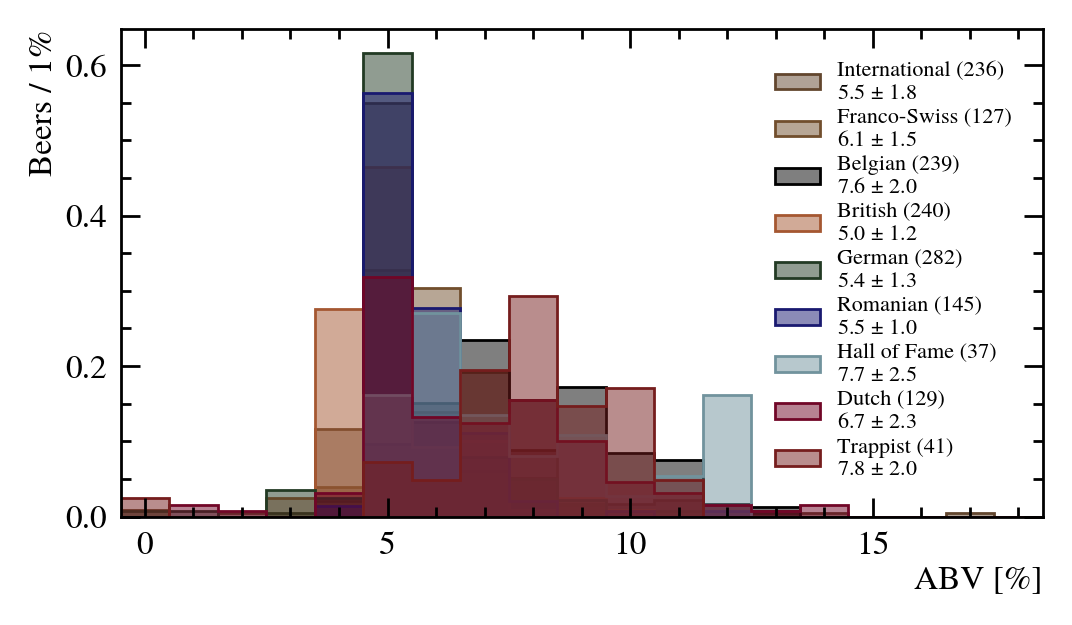

In [71]:
# ABV histogram
fig, ax = plt.subplots(figsize=(16*.66,9*.66))
plt.tight_layout()
plt.margins(x=0)
ps, ls = [], []
for storage in [sChonkyBrown, sChonkyBrown2, sTallBlack, sBigBrown, sGreen, sBlue, sWhite, sRed, sSkinny]:
    dS = df[df.Storage == storage.name]
    hABV = np.histogram(dS.ABV, np.linspace(-.5,18.5,20))
    muABV = np.mean(dS.ABV)
    stdABV = np.std(dS.ABV)
    label = storage.description + f' ({len(dS)})\n' + fr'{muABV:.1f} $\pm$ {stdABV:.1f}'
    plotBorderedHist(hABV, ps, ls, storage.colour, 0.5, label, density=True)
    plt.xlabel('ABV [%]')
    plt.ylabel("Beers / 1%")

applyUniformFont(ax,24)
leg = plotOrderedLegend(list(range(len(ps))), ps, ls, loc='upper right', fontsize=16)
plt.show()
# saveAndListPlot("histABV_storage.pdf", "Histogram of ABVs for each storage")

In [ ]:
# do it in 3D
# NB: relies on the legend from the previous plot
binning = np.linspace(-.5,18.5,20)
nStorage = len(storages) + 1

fig = plt.figure(figsize=(16,9))
ax = fig.add_axes([0,0,1,1], projection='3d')
ax.margins(x=0, y=0, z=0)
ax.set_box_aspect([3,6,3])
ax.view_init(elev=15, azim=-45)
# ax.view_init(elev=30, azim=-60)
ax.minorticks_off()
ax.zaxis.set_minor_locator(plt.NullLocator())
# ax.autoscale(axis='y', tight=False)

# Set a white background color
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

for division in [0, 5, 10, 15,]: ax.plot([division]*(nStorage-1), range(1, nStorage), c='black', lw=2)
ax.plot([0, binning[-1]], [nStorage-1, nStorage-1], c='black', lw=2)
ax.set_xlabel('ABV [%]', labelpad=10)
ax.set_ylabel("Storage", labelpad=10)
ax.set_zlabel("Beers / 1% (normalised)", labelpad=15)

ax.grid(False)
plt.tick_params(axis='both', which='both', pad=0)
plt.tick_params(axis='z', which='both', pad=9)
applyUniformFont(ax, 18, in3d=True)

for i, storage in enumerate(storages):
    dS = df[df.Storage == storage.name]
    hABV, _ = np.histogram(dS.ABV, binning)
    norm = sum(hABV)*(binning[1]-binning[0])

    muABV = np.mean(dS.ABV)
    stdABV = np.std(dS.ABV)

    ax.bar(binning[:-1], hABV/norm, width=binning[1]-binning[0], color=storage.colour, align='edge', zs=i+1, zdir='y', alpha=.5)
    # Add outlines at the top of the bars
    for j in range(len(binning)-1): 
        ax.plot([binning[j], binning[j+1]], [hABV[j]/norm, hABV[j]/norm], zs=i+1, zdir='y', color=storage.colour, linewidth=1)
        ax.plot([binning[j], binning[j]], [hABV[j]/norm, hABV[j-1]/norm], zs=i+1, zdir='y', color=storage.colour, linewidth=1)

plotOrderedLegend(list(range(len(ps))), ps, ls, loc='upper left', fontsize=16, kwargs=dict(ncol=4))

def update(elev=15, azim=-45): 
    ax.view_init(elev, azim)
    fig.canvas.draw_idle()
    fig.canvas.draw()

interact(update);


# plt.show()

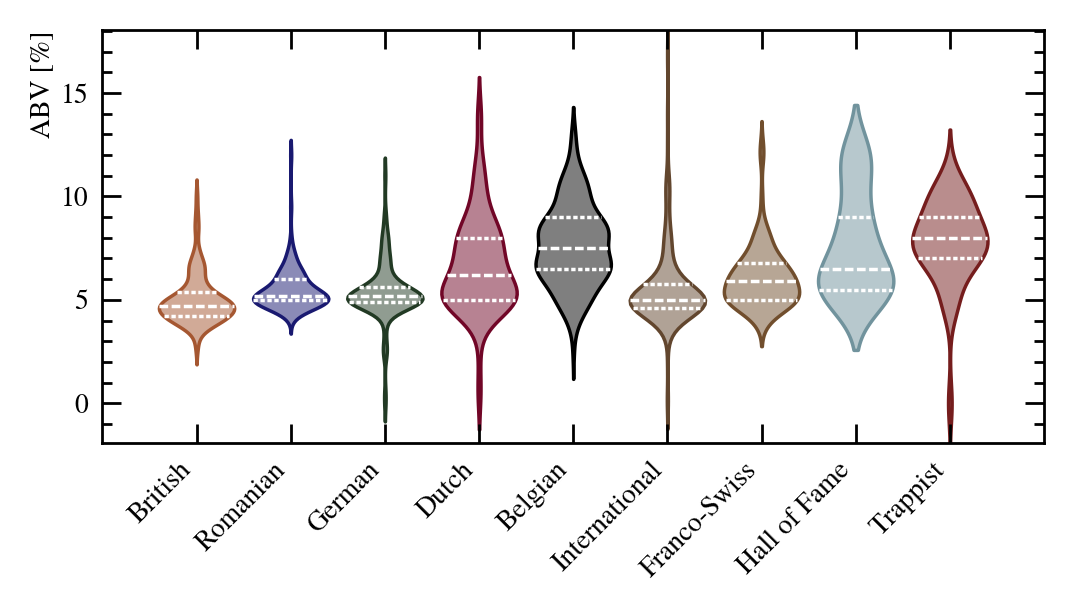

In [85]:
# violin version
fig, ax = plt.subplots(figsize=(16*.66,9*.66))
ax.margins(x=0, y=0)
ax.xaxis.set_minor_locator(plt.NullLocator())

ax.set_ylabel("ABV [%]")#, labelpad=35)

violins = []
for i, storage in enumerate(storages):
    dS = df[df.Storage == storage.name]
    violins.append(sorted(dS.ABV))

ax = sns.violinplot(data=violins, orient='v', label='bla', linecolor='white', inner='quart') # "box": miniature box-and-whisker plot; "quart": quartiles of the data; "point" or "stick": each observation
for i, violin in enumerate(ax.collections): 
    violin.set_edgecolor(storages[i].colour)
    violin.set_facecolor(matplotlib.colors.to_rgba(storages[i].colour, .5))

ax.set_xlim([-1, len(storages)])
# ax.set_ylim([0,20])
ax.set_xticks(range(len(storages)), [storage.description for storage in storages], rotation=45, ha='right')
applyUniformFont(ax, 20)

/var/folders/dx/41cd57nj0wd7ssx9b1z74rjc0000gn/T/ipykernel_14241/156351522.py:9: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  btypes = list(set(np.concatenate([x.split(', ') for x in pd.value_counts(d.Type).index])))[1:] # split composite types, ignore empty values
/var/folders/dx/41cd57nj0wd7ssx9b1z74rjc0000gn/T/ipykernel_14241/156351522.py:29: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/var/folders/dx/41cd57nj0wd7ssx9b1z74rjc0000gn/T/ipykernel_14241/156351522.py:30: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/var/folders/dx/41cd57nj0wd7ssx9b1z74rjc0000gn/T/ipykernel_14241/156351522.py:31: MatplotlibDeprecationWarning: The 

/Users/rm1613/Documents/ion-production-at-lhcb/venv-3p12/lib/python3.12/site-packages/ipympl/backend_nbagg.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.figure.savefig(buf, format='png', dpi='figure')


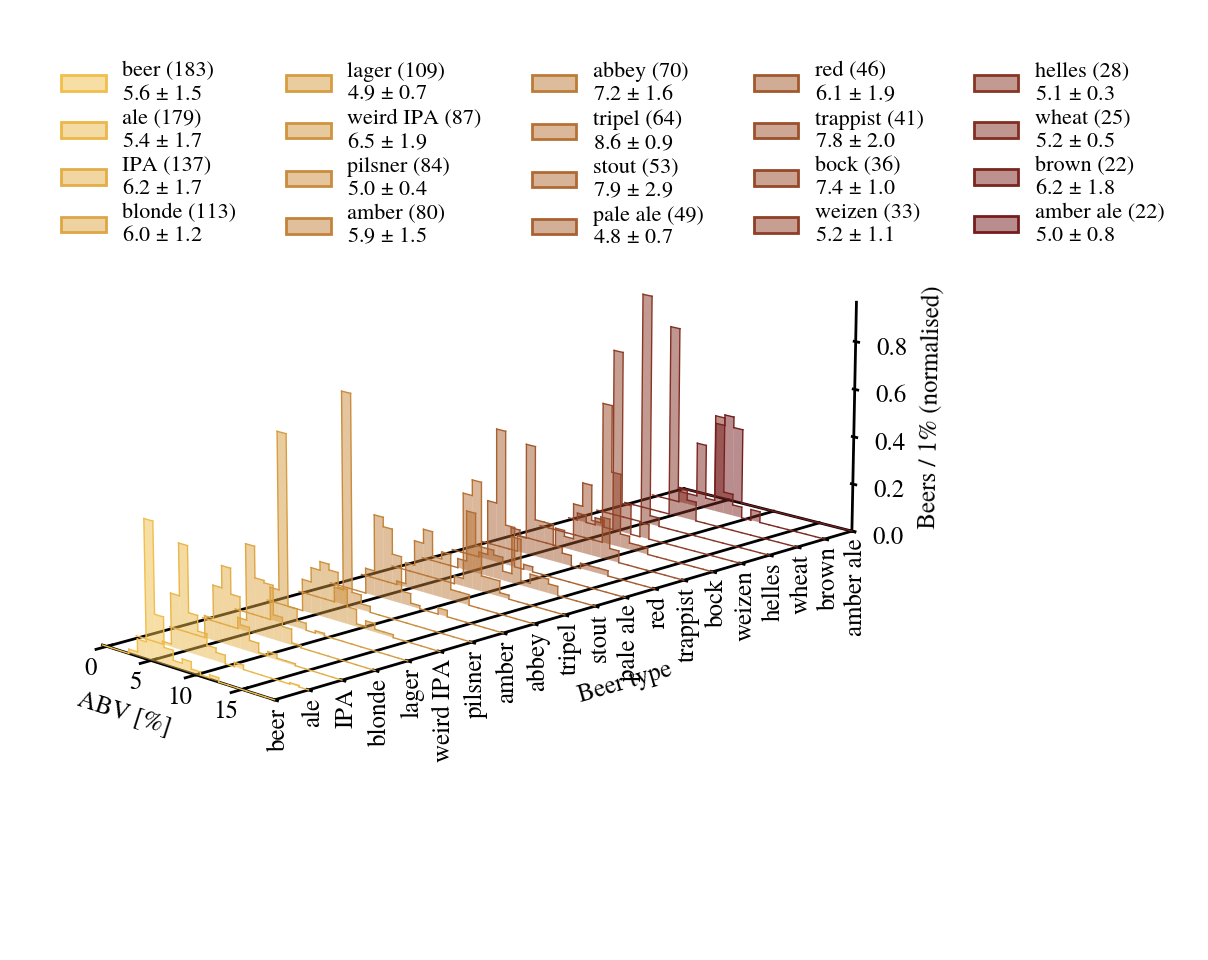

/Users/rm1613/Documents/ion-production-at-lhcb/venv-3p12/lib/python3.12/site-packages/ipympl/backend_nbagg.py:279: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.manager.handle_json(content)


In [6]:
# Group by beer type 
d = df.copy()
d['Type'] = d['Type'].fillna('')
d.loc[(d['Type'].str.contains('IPA'))&(d['Type']!='IPA'), 'Type'] = 'weird IPA'
d.loc[(d['Type']=='pils'), 'Type'] = 'pilsner'
d.loc[(d['Type']=='weissbier'), 'Type'] = 'weizen'
d.loc[(d['Type']=='hell'), 'Type'] = 'helles'

btypes = list(set(np.concatenate([x.split(', ') for x in pd.value_counts(d.Type).index])))[1:] # split composite types, ignore empty values
counts = [(btype, sum([1 for typ in d.Type if btype in typ])) for btype in btypes]

nCounts = 20
countsType = sorted(counts, key=lambda x: x[1], reverse=True)[:nCounts] 
# countsType = pd.value_counts(d.Type)[:nCounts]
colours = sampleCmapColours('beer', nCounts)
ps, ls = [], []

fig = plt.figure(figsize=(16,9))
ax = fig.add_axes([0,0,1,1], projection='3d')
ax.margins(x=0, y=0, z=0)
ax.set_box_aspect([3,10,3])
ax.view_init(elev=15, azim=-45)
# ax.view_init(elev=30, azim=-60)
ax.minorticks_off()
ax.zaxis.set_minor_locator(plt.NullLocator())
# ax.autoscale(axis='y', tight=False)

# Set a white background color
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

for division in [0, 5, 10, 15,]: ax.plot([division]*(nCounts), range(nCounts), c='black', lw=2)
ax.plot([0, binning[-1]], [nCounts-1, nCounts-1], c='black', lw=2)
ax.set_xlabel('ABV [%]', labelpad=10)
ax.set_ylabel("Beer type", labelpad=60)
# ax.set_yticks(list(range(nCounts)), countsType.index, rotation=90)
ax.set_yticks(list(range(nCounts)), [x[0] for x in countsType], rotation=90)
ax.set_zlabel("Beers / 1% (normalised)", labelpad=15)

ax.grid(False)
plt.tick_params(axis='both', which='both', pad=0)
plt.tick_params(axis='z', which='both', pad=9)
applyUniformFont(ax, 18, in3d=True)

# for i, btype in enumerate(countsType.index):
for i, (btype, count) in enumerate(countsType):
    dS = d[d.Type.str.contains(btype)]
    hABV, _ = np.histogram(dS.ABV, binning)
    norm = sum(hABV)*(binning[1]-binning[0])
    # norm=1.

    muABV = np.mean(dS.ABV)
    stdABV = np.std(dS.ABV)

    pFill = mpatches.Patch(fc=colours[i], alpha=.5, label=btype)
    pStep = mpatches.Patch(ec=colours[i], color='none')
    ps.append((pStep, pFill))
    ls.append(f'{btype} ({count}) \n'+fr'{muABV:.1f} $\pm$ {stdABV:.1f}')

    ax.bar(binning[:-1], hABV/norm, width=binning[1]-binning[0], color=colours[i], align='edge', zs=i, zdir='y', alpha=.5)
    # Add outlines at the top of the bars
    for j in range(len(binning)-1): 
        ax.plot([binning[j], binning[j+1]], [hABV[j]/norm, hABV[j]/norm], zs=i, zdir='y', color=colours[i], linewidth=1)
        ax.plot([binning[j], binning[j]], [hABV[j]/norm, hABV[j-1]/norm], zs=i, zdir='y', color=colours[i], linewidth=1)

plotOrderedLegend(list(range(len(ps))), ps, ls, loc='upper left', fontsize=16, kwargs=dict(ncol=5))

# Histogram of ABVs

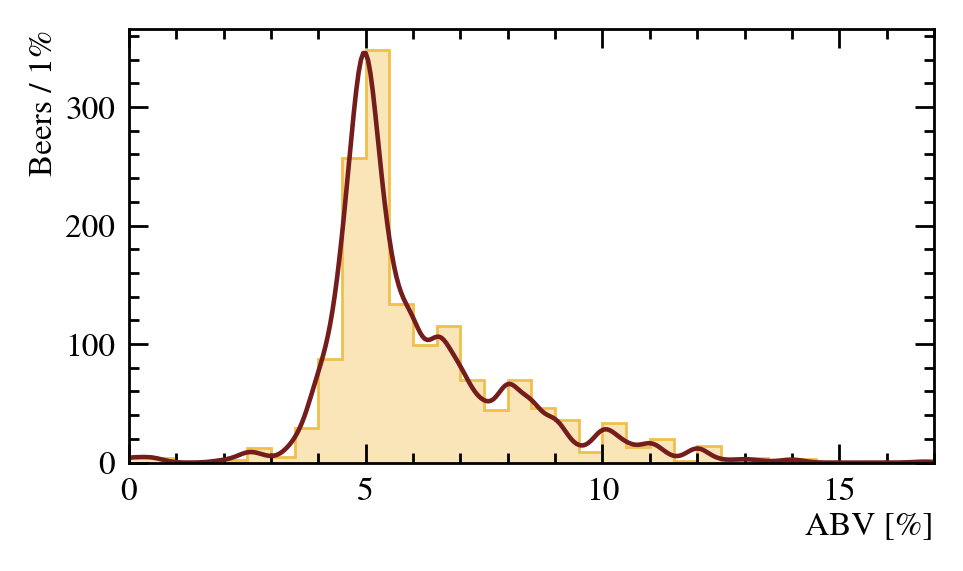

In [8]:
abv = df.ABV.dropna()
hABV = np.histogram(abv, np.linspace(0,17,35))
kdeABV = stats.gaussian_kde(abv, bw_method=.125)

fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
plotBorderedHist(hABV, [], [], clr.beeryellow, .4)
plt.plot(np.linspace(0,17,341), .5*len(abv)*kdeABV(np.linspace(0,17,341)), clr.beerbrown) 
plt.xlabel('ABV [%]')
plt.ylabel("Beers / 1%")
applyUniformFont(ax,24)
plt.show()
# plt.savefig("histABV.pdf", "Histogram of ABVs")
# plt.close()

# Histogram of countries

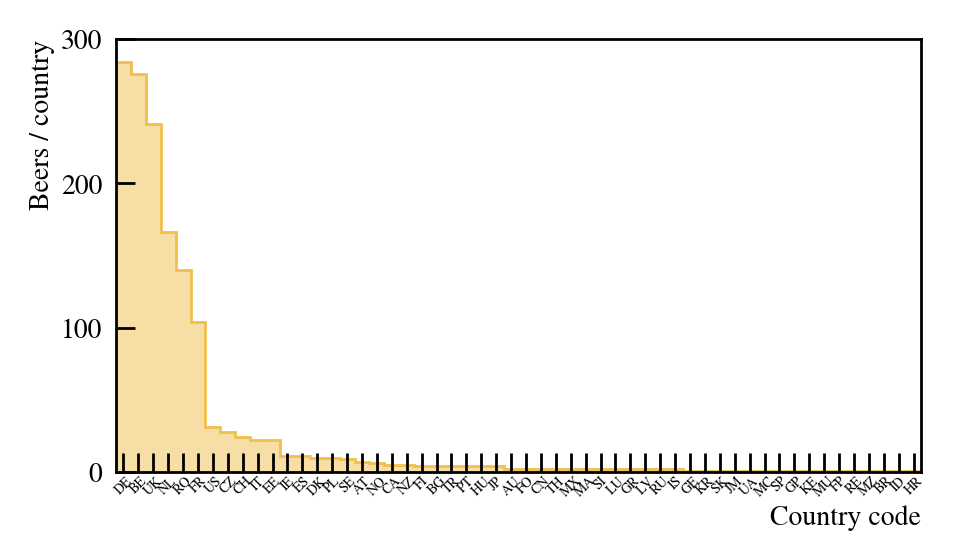

In [9]:
dg = df.Country.value_counts()
bins = np.linspace(0,len(dg),len(dg)+1)
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
histplot(dg, bins, color='#f1bf4b', histtype="fill", alpha=.5)
histplot(dg, bins, color='#f1bf4b', histtype="step")
ax.set_xticks(.5*(bins[1:]+bins[:-1]))
ax.minorticks_off()
plt.xlabel('Country code')
plt.ylabel("Beers / country")
applyUniformFont(ax,20)
ax.set_xticklabels(dg.index, fontsize=10, rotation=45)
plt.tick_params(axis='x', pad=1)
plt.tick_params(axis='both', top=False,right=False)
ax.set_ylim(top=300)
# ax.set_yscale('log')
plt.show()

# ABV per country

/Users/rm1613/Documents/ion-production-at-lhcb/venv-3p12/lib/python3.12/site-packages/iminuit/cost.py:2473: PerformanceWarning: model should return numpy array, but returns <class 'float'>
  warnings.warn(msg, PerformanceWarning)
/Users/rm1613/Documents/ion-production-at-lhcb/venv-3p12/lib/python3.12/site-packages/iminuit/cost.py:2473: PerformanceWarning: model should return numpy array, but returns <class 'float'>
  warnings.warn(msg, PerformanceWarning)


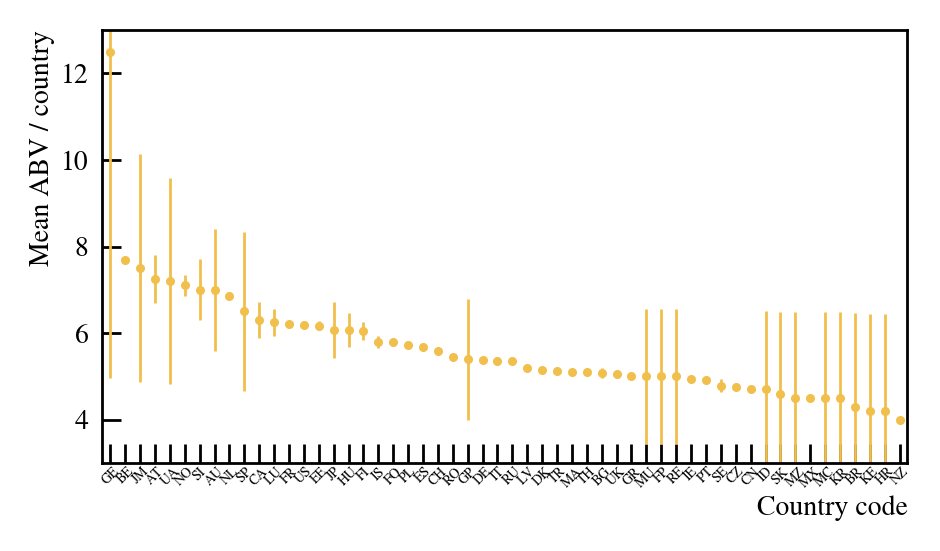

In [10]:
dGrp = df.groupby("Country")
means = dGrp.ABV.mean()
eoms = dGrp.ABV.std() / dGrp.ABV.count()
dh = pd.concat([means,eoms], keys=['MeanABV','ErrorOnABV'], axis=1)
dh = dh.sort_values('MeanABV',ascending=False)

# where there's only one entry, use the KDE to set a 68% credible interval as uncertainty
for _, row in dh.iterrows():
    if np.isnan(row.ErrorOnABV):
        def CISymmetric(_, x): return kdeABV.integrate_box(row.MeanABV-x, row.MeanABV+x) - .6827
        m = Minuit(LeastSquares([0], [0], 1e-5, CISymmetric), x=1)
        result = m.migrad()
        row.ErrorOnABV = result.params['x'].value

fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0.01)
plt.errorbar(.5*(bins[1:]+bins[:-1]), dh.MeanABV, dh.ErrorOnABV, False, ls='', marker='.', markersize=10, elinewidth=2, capsize=0, color='#f1bf4b')
ax.set_xticks(.5*(bins[1:]+bins[:-1]))
ax.minorticks_off()
plt.xlabel('Country code')
plt.ylabel("Mean ABV / country")
applyUniformFont(ax,20)
ax.set_xticklabels(dh.index, fontsize=10, rotation=45)
ax.set_ylim([3,13])
plt.tick_params(axis='x', pad=1)
plt.tick_params(axis='both', top=False,right=False)
plt.show()

# Time evolution

In [11]:
dates = [dt.datetime(2018,3,27,0,0), dt.datetime(2019,9,26,0,0), dt.datetime(2020,12,8,0,0), dt.datetime(2021,6,27,0,0), dt.datetime(2022,1,27,0,0), dt.datetime(2025,1,1,0,0)]
locations = ['CERN', 'London', 'RO', 'London', 'DENL']
def plotLandmarkDates(y, zorder=-99):
    for i in range(len(locations)):
        plt.axvline(x=dates[i], c='#9C4431', ls='--', zorder=zorder) # F1DD59 # EED892
        plt.text(dates[i]+dt.timedelta(days=15), y, locations[i], c='w', va='top', zorder=zorder, path_effects=[pe.Stroke(linewidth=.5, foreground='#9C4431')])

In [12]:
# Process the data
df['Date'] = pd.to_datetime(df['Date'], errors='coerce',format='%d/%m/%Y')
day0 = np.mean(df.Date).date()
dDates = df[pd.notna(df['Date'])][['Number','Date','ABV','Storage']]
dDates['usableDate'] = [(x.date() - dt.date(2018,1,1)).days for x in dDates['Date']]
dDates = dDates.query('usableDate > 0')
dDates = dDates[pd.notna(dDates['Number'])]
dDates['x'] = [(x.date() - day0).days for x in dDates['Date']]
# please the mathematicians
# dDates['costheta'] = dDates['x'] * 2 / (dDates.x.max() - dDates.x.min()) 
# dDates['y'] = dDates['Number'] * 2 / (dDates.Number.max() - dDates.Number.min())

# fit a 2nd order Chebychev polynomial
def cheby2(x, c0=0, c1=1, c2=0):
    return c0 + c1 * x + c2 * (2*x*x - 1)
# fit a 4thd order Chebychev polynomial
def cheby4(x, c0=0, c1=1, c2=0, c3=0, c4=0):
    return cheby2(x,c0,c1,c2) + \
    c3 * (4*x*x*x - 3*x) + \
    c4 * (8*x*x*x*x - 8*x*x - 1)
def expo(x, norm, x0, shift): return norm*np.exp((x+min(dDates.x))/x0)+shift

# minimiser = Minuit(LeastSquares(np.array(dDates.x), np.array(dDates.Number), np.ones_like(dDates.Number), cheby4), 
# minimiser = Minuit(LeastSquares(np.array(dDates.x), np.array(dDates.Number), np.ones_like(dDates.Number), cheby2), 
#     c0 = 600, 
#     c1 = .5,
#     c2 = 1e-5,
    # c3 = 1e-5,
    # c4 = 1e-5,
    # )
minimiser = Minuit(LeastSquares(np.array(dDates.x), np.array(dDates.Number), np.ones_like(dDates.Number), expo), 
    norm = 1500, 
    x0 = 2000,
    shift = 300,
    )
result = minimiser.migrad()
param_hesse = result.hesse()
param_errors = result.errors

fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {minimiser.fval:1.1e} / {len(dDates) - minimiser.nfit}",
]
for p, v, e in zip(minimiser.parameters, minimiser.values, minimiser.errors):
    if not minimiser.fixed[p]:
        fit_info.append(f"{p} = ${v:1.1e} \\pm {e:1.1e}$")

In [51]:
result

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.394e+05 (χ²/ndof = 582.6)│              Nfcn = 178              │
│ EDM = 7.21e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm  │ 2.0639e3  │ 0.0004e3  │            │            │         │         │       │
│ 1 │ x0    │ 1.7686e3  │ 0.0009e3  │            │            │         │         │       │
│ 2 │ shift │  -308.1   │    0.5    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │  norm    x0 shift │
├───────┼───────────────────┤
│  norm │ 0.164  0.32 -0.20 │
│    x0 │  0.32 0.754 -0.44 │
│ shift │ -0.20 -0.44 0.266 │
└───────┴───────────────────┘

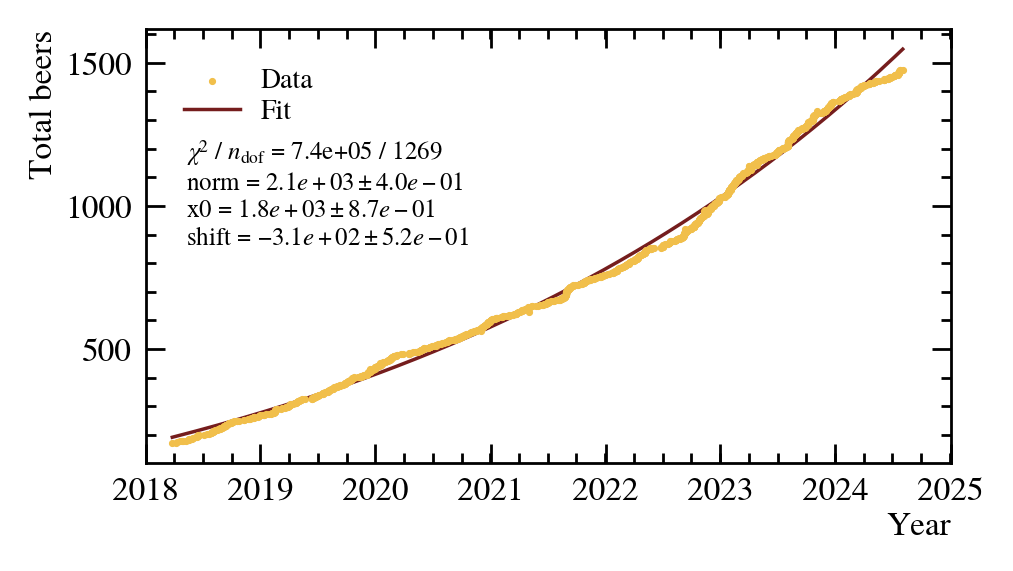

In [13]:
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
plt.xlabel('Year')
plt.ylabel('Total beers')
# plt.plot(np.sort(dDates.Date), cheby4(np.sort(dDates.x), *minimiser.values), color='#751D1D', lw=2.5, zorder=-99, label='Fit')
plt.plot(np.sort(dDates.Date), expo(np.sort(dDates.x), *minimiser.values), color='#751D1D', lw=2.5, zorder=-99, label='Fit')
plt.scatter(dDates.Date, dDates.Number, color='#f1bf4b', s=10, label='Data')
# plt.scatter(dDates.x, dDates.Number, color='#f1bf4b', s=10, label='Data')
plotOrderedLegend([1,0])
ax.set_xlim([dt.date(2018,1,1), dt.date(2025,1,1)])
applyUniformFont(ax,24)
# plotLandmarkDates(1250)
plt.text(.05,.75, "\n".join(fit_info), transform=ax.transAxes, fontsize=18, ha='left', va='top')
plt.show()

# Time evolution of mean ABV

In [32]:
def rollingMeanVariance(l, mu=0, v=0, i0=0):
    mus, vs = [], []
    n = len(l)
    for i in range(n):
        delta = l[i] - mu
        mu += delta / (i+1+i0)
        mus.append(mu)
        v += (l[i] - mu) * delta
        vs.append(v / (i+1+i0))
    return mus, vs

In [33]:
dh = df[pd.notna(df['ABV'])][['Number','Date','ABV']]
# start with the mean before dating
mBefore = [pd.isna(x) or (x.date() - dt.date(2018,1,1)).days < 0 for x in dh['Date']]
listBefore = np.sort(dh[mBefore]['ABV'])
mus, vs = rollingMeanVariance(listBefore)
mu0, v0 = mus[-1], vs[-1]
nBefore = len(dh[mBefore])

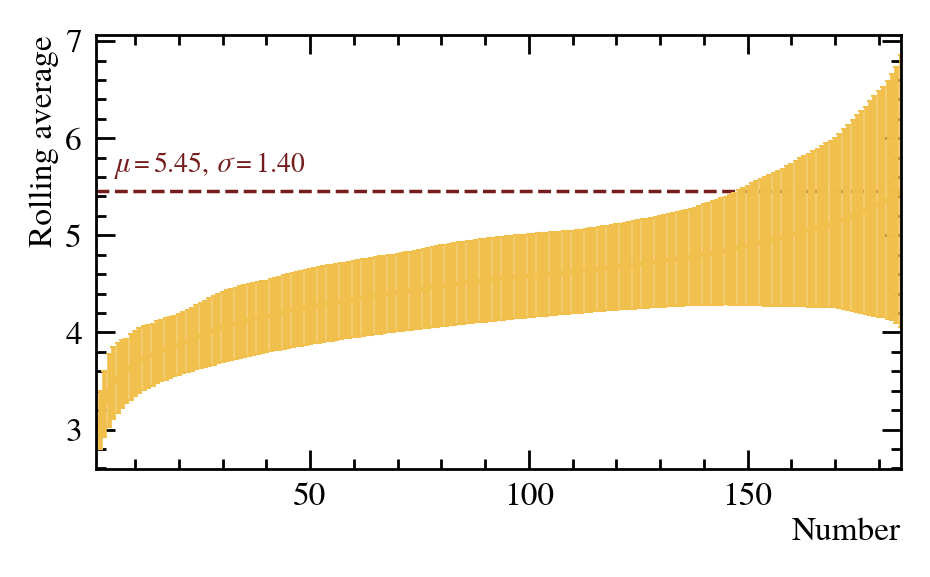

In [34]:
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
plt.xlabel('Number')
plt.ylabel('Rolling average')
# plt.errorbar(range(1,nBefore+1), mu0, vs0, color='#f1bf4b')
plt.axhline(y=mu0, color='#751D1D', lw=2.5, zorder=-99, ls='--')
plt.text(5, mu0+.2, f"$\\mu={mu0:.2f}$, $\\sigma={v0 **.5:.2f}$", color='#751D1D', fontsize=20)
plt.errorbar(range(1,nBefore+1), mus, np.sqrt(vs), color='#f1bf4b') # NB the error bars are not the error on the mean
applyUniformFont(ax,24)
plt.show()

In [35]:
# Continue with the entries that have a usable date
mAfter = [pd.notna(x) and (x.date() - dt.date(2018,1,1)).days > 0 for x in dh['Date']]
dAfter = dh[mAfter].sort_values('Date').reset_index()
listAfter = dAfter.ABV
nAfter = len(listAfter)
mus, vs = rollingMeanVariance(listAfter, mu0, v0*nBefore, nBefore)
mus.insert(0,mu0)
vs.insert(0,v0)
len(mus), nAfter
errs = []
for i in range(len(mus)):
    errs.append((vs[i]/(i+nBefore))**.5)

<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
/var/folders/dx/41cd57nj0wd7ssx9b1z74rjc0000gn/T/ipykernel_59911/1899581933.py:9: SyntaxWarning: invalid escape sequence '\p'
  plt.text(np.max(dAfter.Date), mus[-1], f"$({mus[-1]:.2f}\pm{errs[-1]:.2f})\\%$", color='#751d1d', va='center', rotation=-90, fontsize=14)


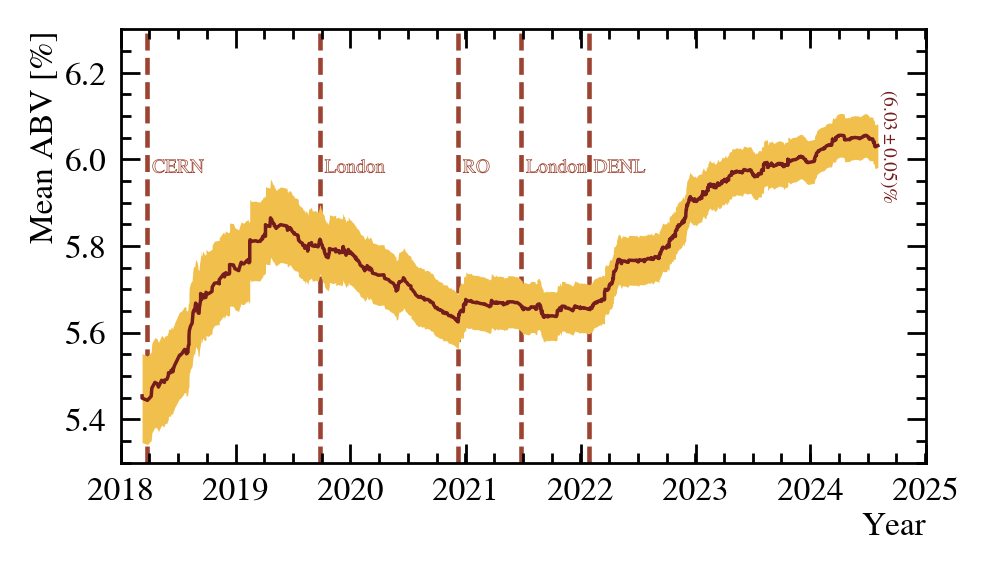

In [36]:
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
plt.xlabel('Year')
plt.ylabel('Mean ABV [%]')
# plt.errorbar([dAfter.Date[0]] + list(dAfter.Date), mus, errs, color='#f1bf4b', ls='',marker='.', markersize=.5, elinewidth=1, capthick=1, capsize=.5, lw=.5) 
ax.fill_between([dAfter.Date[0]] + list(dAfter.Date), np.array(mus)+errs, np.array(mus)-errs, color='#f1bf4b', lw=0)
p1 = ax.plot([dAfter.Date[0]] + list(dAfter.Date), mus, color='#751d1d', lw=2.5, label='bla')
plt.text(np.max(dAfter.Date), mus[-1], f"$({mus[-1]:.2f}\pm{errs[-1]:.2f})\\%$", color='#751d1d', va='center', rotation=-90, fontsize=14)
ax.set_xlim([dt.date(2018,1,1), dt.date(2025,1,1)])
ax.set_ylim([5.3,6.3])
plotLandmarkDates(6)
applyUniformFont(ax,24)
plt.show()

# Separation by (rough) location when drunk

In [37]:
mBefore = [pd.isna(x) or (x.date() - dt.date(2018,1,1)).days < 0 for x in df['Date']]
mAfter = [pd.notna(x) and (x.date() - dt.date(2018,1,1)).days > 0 for x in df['Date']]
d = df[mAfter]
d['Timestamp'] = [x.timestamp() for x in d['Date']]

dates = [dt.datetime(2018,3,27,0,0), dt.datetime(2019,9,26,0,0), dt.datetime(2020,12,8,0,0), dt.datetime(2021,6,27,0,0), dt.datetime(2022,1,27,0,0), dt.datetime(2025,1,1,0,0)]
timestamps = [x.timestamp() for x in dates]
locations = ['CERN', 'London', 'RO', 'London', 'DENL']
d['Location'] = pd.cut(d['Timestamp'], bins=timestamps, labels=locations, ordered=False)

/var/folders/dx/41cd57nj0wd7ssx9b1z74rjc0000gn/T/ipykernel_59911/2915290294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Timestamp'] = [x.timestamp() for x in d['Date']]
/var/folders/dx/41cd57nj0wd7ssx9b1z74rjc0000gn/T/ipykernel_59911/2915290294.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Location'] = pd.cut(d['Timestamp'], bins=timestamps, labels=locations, ordered=False)


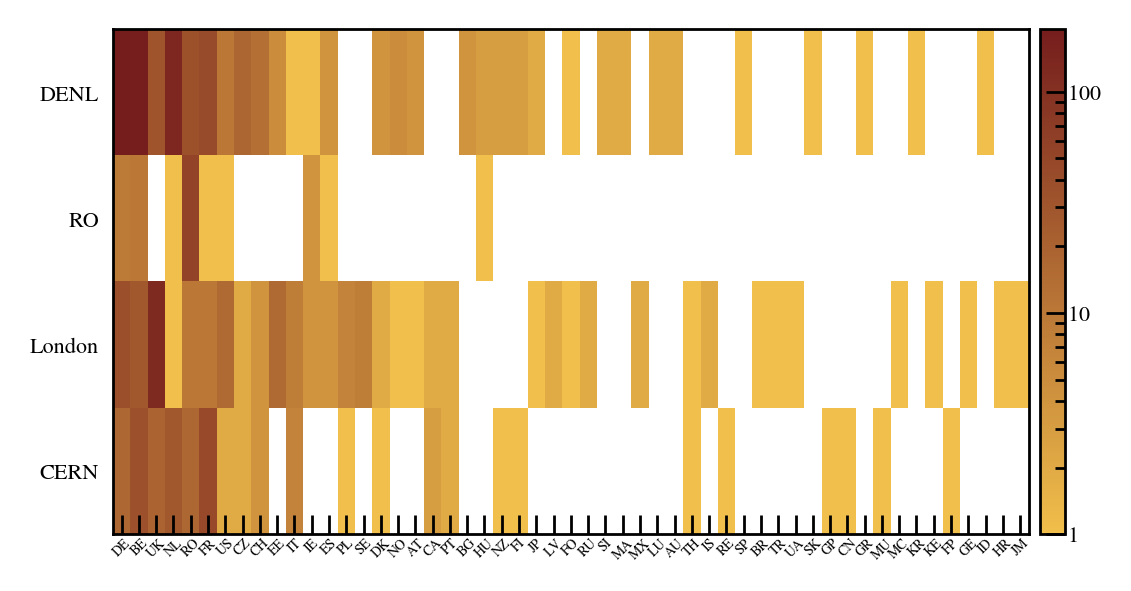

In [38]:
counts = d['Country'].value_counts()
d = d[d['Country'].isin(counts.index)].sort_values(by='Country', key=lambda x: x.map(counts), ascending=False)

xtab = pd.crosstab(d.Location, d.Country)
xtab = xtab[xtab.sum().sort_values(ascending=False).index].reindex(['CERN','London','RO','DENL'][::-1])
fig, ax = plt.subplots(figsize=(18*.6,9*.6), layout='constrained')
plt.margins(x=0)
im = ax.imshow(xtab, aspect='auto', rasterized=True, norm=LogNorm(), 
              cmap=LinearSegmentedColormap.from_list("beer",colors=['#f1bf4b','#751d1d']))
locs = xtab.index.tolist()
countries = xtab.columns.tolist()

# Set axis labels and tick positions
plt.yticks(range(len(locs)), locs)
applyUniformFont(ax,16)
plt.xticks(range(len(countries)), countries, rotation=45, fontsize=10)
plt.minorticks_off()
plt.tick_params(axis='x', pad=1),
plt.tick_params(axis='both', top=False,right=False, left=False)

cbar = fig.colorbar(im, shrink=1., pad=.01)
cbar.ax.tick_params(axis='both', pad=1)
applyUniformFont(cbar.ax,16)
plt.show()

In [39]:
xtab

Country,DE,BE,UK,NL,RO,FR,US,CZ,CH,EE,...,GR,MU,MC,KR,KE,FP,GE,ID,HR,JM
Location,,,,,,,,,,,,,,,,,,,,,
DENL,191,176,31,133,35,42,10,18,13,5,...,1,0,0,1,0,0,0,1,0,0
RO,9,10,0,1,54,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
London,37,28,122,1,10,10,16,2,4,16,...,0,0,1,0,1,0,1,0,1,1
CERN,17,36,19,28,17,45,2,2,4,0,...,0,1,0,0,0,1,0,0,0,0


# Time between 100s

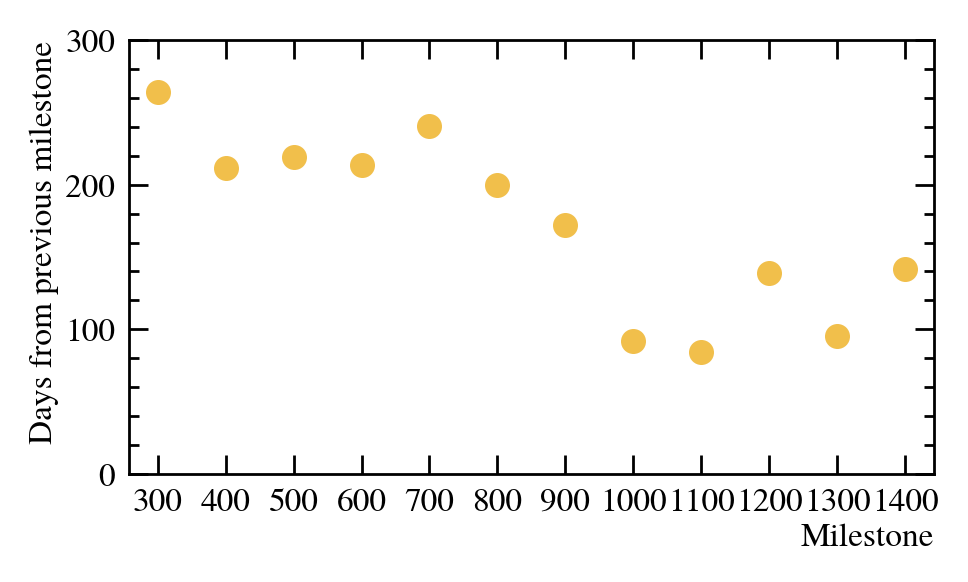

In [40]:
d100 = df[df.Number%100==0].sort_values(by='Number').reset_index(drop=True)
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=50/(max(d100.Number)-min(d100.Number)+100))
plt.xlabel('Milestone')
plt.ylabel('Days from previous milestone')
plt.scatter(np.arange(min(d100.Number)+100, max(d100.Number)+1, 100), [x.days for x in d100['Date'].diff()][1:], color=niceColour('beeryellow'))
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(NullLocator())
ax.set_ylim([0,300])
applyUniformFont(ax, 24)
plt.show()

# How many beers were drunk in a given day

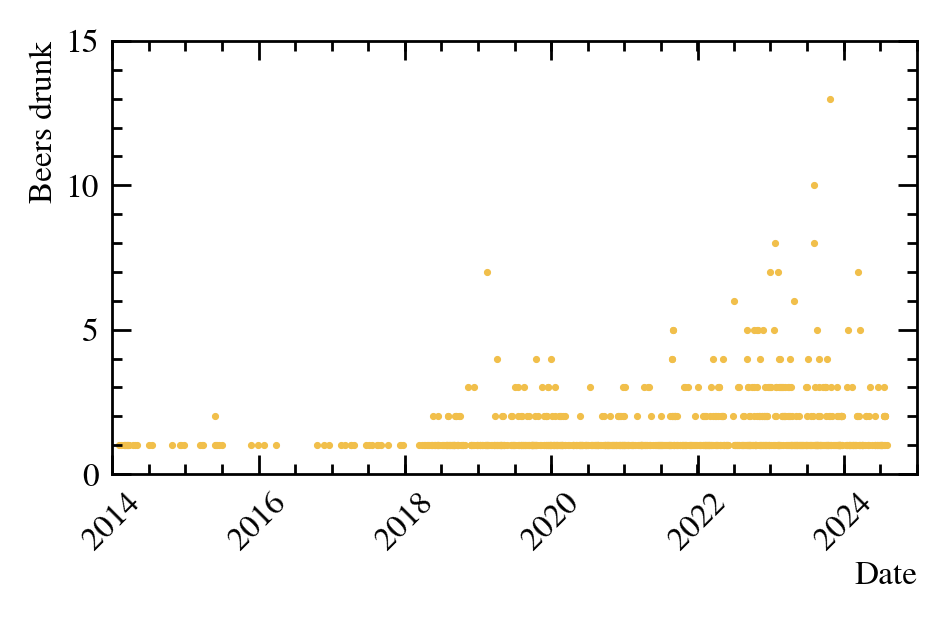

In [41]:
dGrp = df.groupby('Date')
bdrunk = dGrp.size()
# bdrunk.index
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
ax.set_xlabel("Date")
ax.set_ylabel("Beers drunk")
ax.set_ylim([0,15])
ax.set_xlim([dt.date(2014,1,1), dt.date(2025,1,1)])
plt.xticks(rotation=45)
# ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
# ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
plt.scatter(bdrunk.index, bdrunk, s=10, c=niceColour("beeryellow"))
applyUniformFont(ax,24)
plt.show()

In [42]:
hdrunk = bdrunk.value_counts()
errs = np.sqrt(hdrunk.values)
binningFine = np.linspace(.5, max(hdrunk.index)+.5, 100*max(hdrunk.index)+1)

# fit an exponential or a power-law
def expo(x, N=1, l=0): return N*np.exp(-l*(x-1))
def pwr(x, N=1, n=0): return N*x**(-n)

mExpo = Minuit(LeastSquares(hdrunk.index, hdrunk.values, errs, 
                                expo), N=hdrunk.values[0], l=1)
resultExpo = mExpo.migrad()
param_hesse = result.hesse()
param_errors = result.errors

mPwr = Minuit(LeastSquares(hdrunk.index, hdrunk.values, errs, 
                                pwr), N=hdrunk.values[0], n=1)
resultPwr = mPwr.migrad()
param_hesse = result.hesse()
param_errors = result.errors

In [43]:
resultExpo

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 28.1 (χ²/ndof = 3.5)       │              Nfcn = 46               │
│ EDM = 0.0001 (Goal: 0.0002)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N    │    655    │    26     │            │            │         │         │       │
│ 1 │ l    │   1.33    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       N       l │
├───┼─────────────────┤
│ N │     690   0.884 │
│ l │   0.884 0.00377 │
└───┴─────────────────┘

In [44]:
resultPwr

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 23.72 (χ²/ndof = 3.0)      │              Nfcn = 131              │
│ EDM = 2.33e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N    │    701    │    25     │            │            │         │         │       │
│ 1 │ n    │   2.65    │   0.07    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       N       n │
├───┼─────────────────┤
│ N │     645   0.640 │
│ n │   0.640 0.00427 │
└───┴─────────────────┘

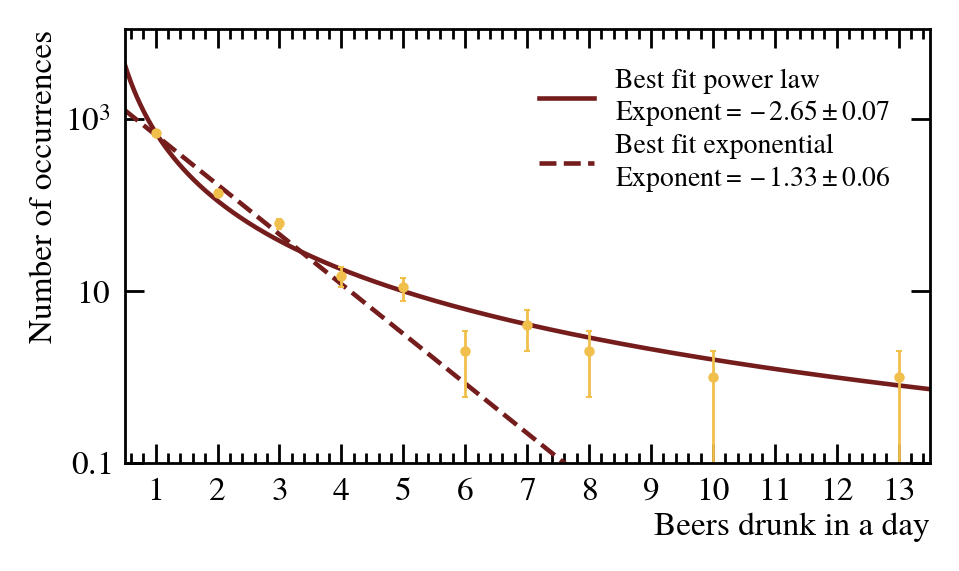

In [46]:
fig, ax = plt.subplots(figsize=(16*.6,9*.6))
plt.tight_layout()
plt.margins(x=0)
ax.set_xlabel("Beers drunk in a day")
ax.set_ylabel("Number of occurrences")
plt.plot(binningFine, expo(binningFine, *mExpo.values), c=clr.beerbrown, ls='--',
         label="Best fit exponential\n"f"Exponent$=-{mExpo.values['l']:.2f}\\pm{mExpo.errors['l']:.2f}$")
plt.plot(binningFine, pwr(binningFine, *mPwr.values), c=clr.beerbrown, 
         label="Best fit power law\n"f"Exponent$=-{mPwr.values['n']:.2f}\\pm{mPwr.errors['n']:.2f}$")
plt.errorbar(hdrunk.index, hdrunk.values, errs, c=clr.beeryellow, ls='', marker='.', markersize=12., capsize=2.5, elinewidth=2, label='Data')
ax.set_xticks(np.linspace(1, max(hdrunk.index), max(hdrunk.index)))

plotOrderedLegend([1,0], loc=1)

ax.set_yscale('log')
ax.set_ylim(bottom=.1)
applyUniformFont(ax,24)
plt.show()

# Convex hulls

In [20]:
from scipy.spatial import ConvexHull, Voronoi, voronoi_plot_2d

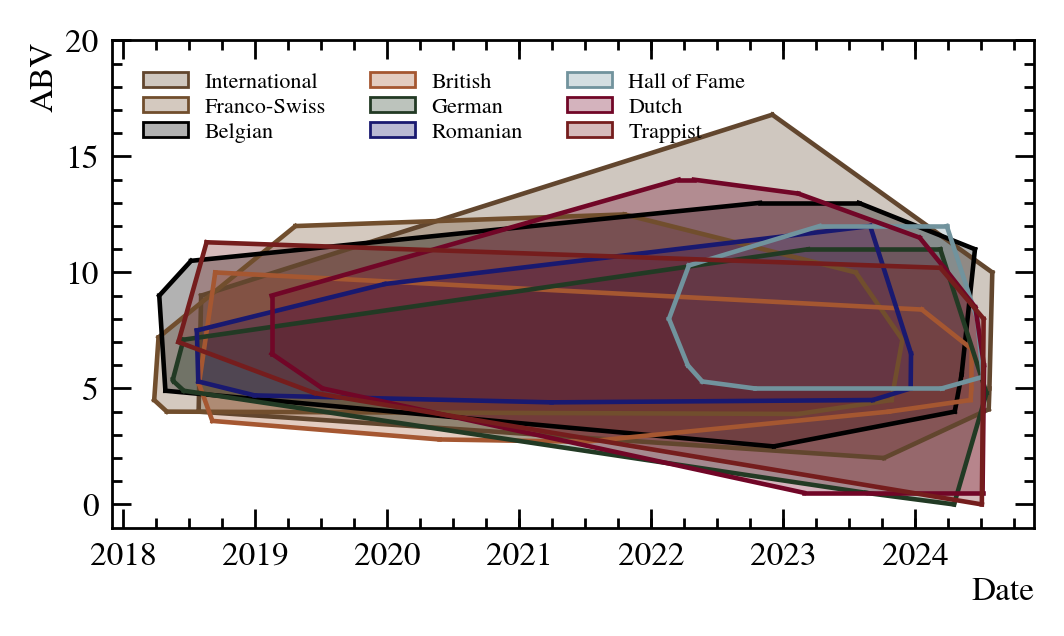

In [27]:
# storages in (ABV, date) space
dDates.dropna(subset=['ABV','Date'], inplace=True)
fig, ax = plt.subplots(figsize=(16*.66,9*.66))
plt.tight_layout()
# plt.margins(x=0)
ax.set_xlabel("Date")
ax.set_ylabel("ABV")
ax.set_ylim([-1,20])

# plt.scatter(points[:,0], points[:,1], s=10, c=niceColour("beeryellow"), zorder=99)

years = range(dt.date(2018,1,1).year, dDates['Date'].dt.year.max() + 1)
plt.xticks(
    ticks=[(dt.date(year, 1, 1) - dt.date(2018,1,1)).days for year in years],
    labels=[str(year) for year in years],  # Display only the year
)

handles=[]
for storage in [sChonkyBrown, sChonkyBrown2, sTallBlack, sBigBrown, sGreen, sBlue, sWhite, sRed, sSkinny]:
    dS = dDates[dDates.Storage == storage.name]
    points = np.array(dS[['usableDate', 'ABV']])
    hull = ConvexHull(points)
    ax.add_patch(plt.Polygon(points[hull.vertices], fc=storage.colour, alpha=.3, lw=0, label=storage.description))
    for simplex in hull.simplices: plt.plot(points[simplex, 0], points[simplex, 1], storage.colour)#, label=storage.description)
    pFill = mpatches.Patch(fc=storage.colour, alpha=.3, label=storage.description)
    pStep = mpatches.Patch(ec=storage.colour, color='none')
    handles.append((pStep, pFill))
    # labels.append(label)
    


plotOrderedLegend(list(range(len(handles))), handles, None, loc='upper left', fontsize=16, kwargs=dict(ncol=3))

applyUniformFont(ax,24)
plt.show()

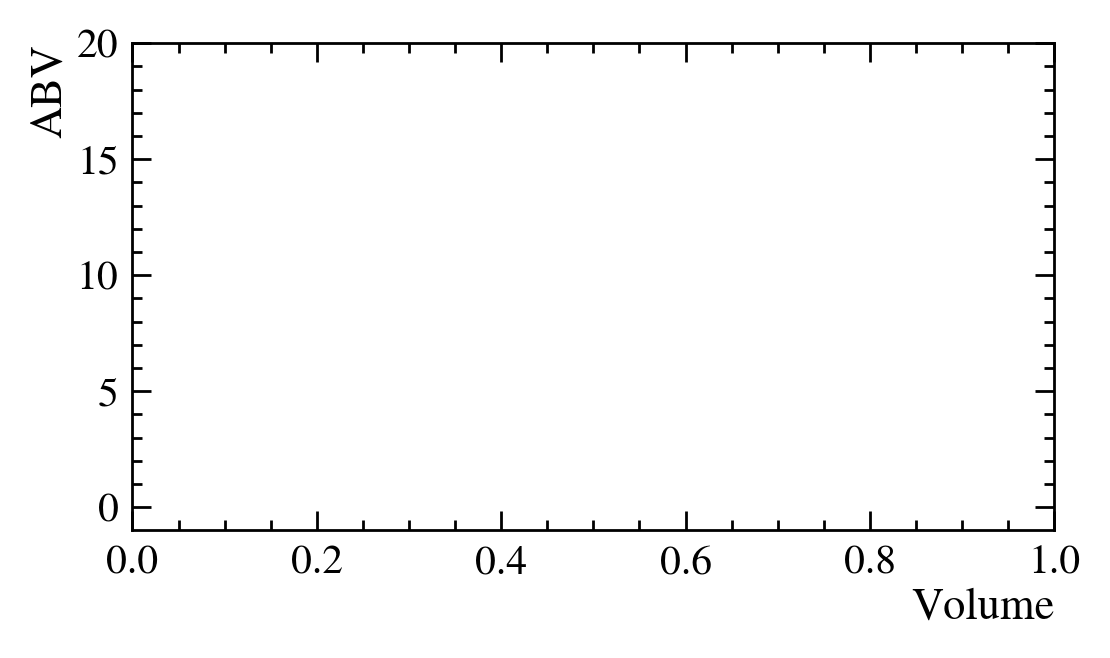

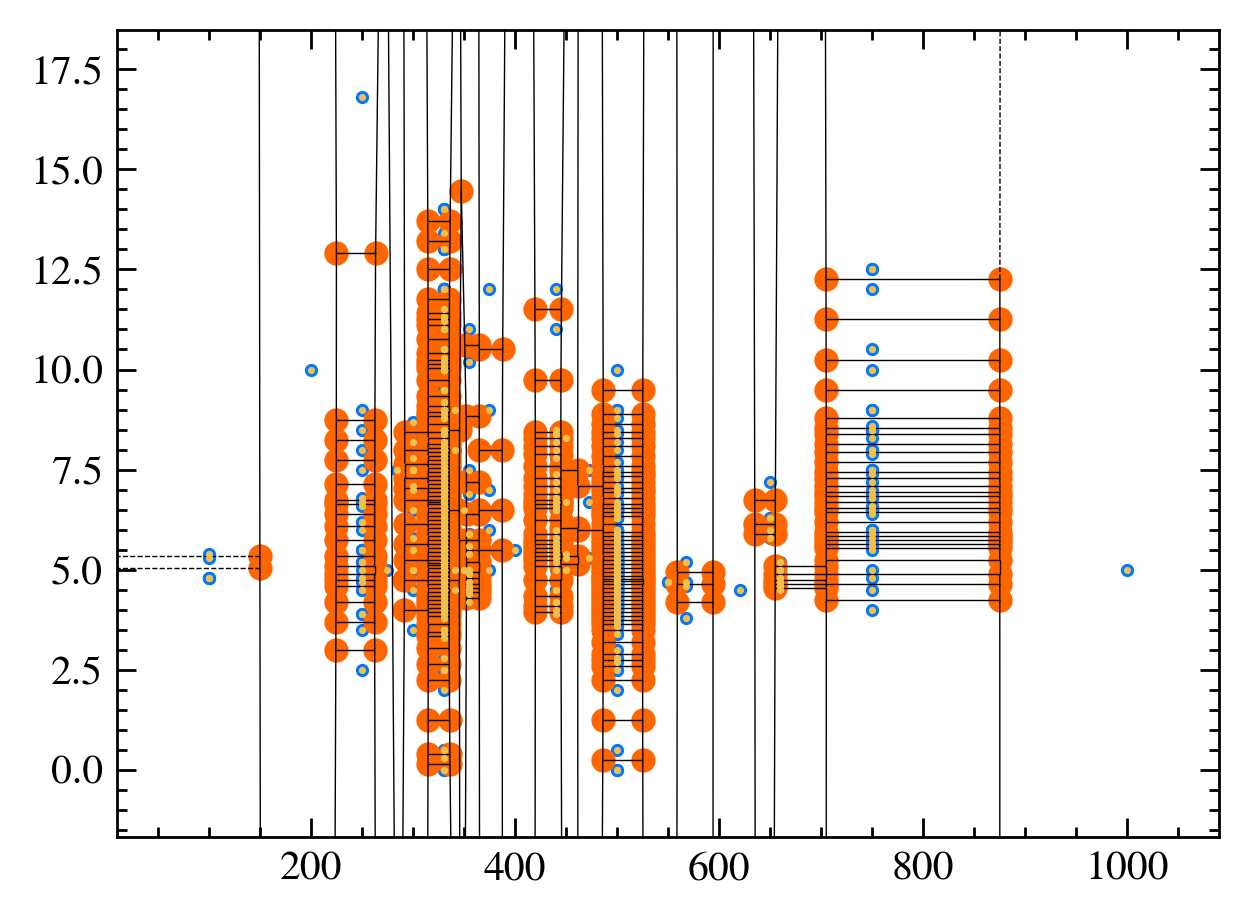

In [34]:
# # voronoi of ABV,vol coloured by storage/country
# doesn't look nice
# subset = ['ABV','Country','Storage','Vol']
# dtmp = df.dropna(subset=subset)[subset]

# fig, ax = plt.subplots(figsize=(16*.66,9*.66))
# plt.tight_layout()
# # plt.margins(x=0)
# ax.set_xlabel("Volume")
# ax.set_ylabel("ABV")
# ax.set_ylim([-1,20])

# handles=[]
# # for storage in [sChonkyBrown, sChonkyBrown2, sTallBlack, sBigBrown, sGreen, sBlue, sWhite, sRed, sSkinny][:1]:
#     # dS = dtmp[dtmp.Storage == storage.name]
# points = np.array(dtmp[['Vol', 'ABV']])
# vor = Voronoi(points)
# voronoi_plot_2d(vor)
#     # ax.add_patch(plt.Polygon(vor.vertices, fc=storage.colour, alpha=.3, lw=0, label=storage.description))
#     # pFill = mpatches.Patch(fc=storage.colour, alpha=.3, label=storage.description)
#     # pStep = mpatches.Patch(ec=storage.colour, color='none')
#     # handles.append((pStep, pFill))
#     # labels.append(label)
    
# plt.scatter(dtmp.Vol, dtmp.ABV, s=10, c=niceColour("beeryellow"), zorder=99)

# # plotOrderedLegend(list(range(len(handles))), handles, None, loc='upper left', fontsize=16, kwargs=dict(ncol=3))

# # applyUniformFont(ax,24)
# # plt.show()

In [28]:
vor.vertices
# hull.vertices

array([[ 1.09870408e+03, -5.81138469e+04],
       [ 2.79559122e+02, -1.64554054e+02],
       [ 8.55976461e+02, -1.76592435e+04],
       [ 8.32097196e+02, -1.42134346e+03],
       [ 2.67084559e+02,  5.10000000e+00],
       [ 2.66685441e+02,  1.10000000e+01],
       [ 7.05325000e+02,  4.85000000e+00],
       [ 4.24914699e+02, -8.41749398e+02],
       [ 7.05351111e+02,  4.55000000e+00],
       [ 7.05342333e+02,  4.65000000e+00],
       [ 4.09074684e+02, -5.06672152e+02],
       [ 3.72162500e+02, -1.74462500e+02],
       [ 6.46284534e+02, -4.23896017e+03],
       [ 6.16321292e+02,  1.07289449e+03],
       [ 6.01526778e+02,  1.44174403e+03],
       [ 5.68417642e+02,  7.97018977e+03],
       [ 5.55192074e+02,  4.26703083e+03],
       [ 2.93244405e+02,  1.08097287e+02],
       [ 3.06752717e+02,  1.25000000e+01],
       [ 3.47417073e+02, -2.71682927e+01],
       [ 3.47232143e+02, -2.64285714e+01],
       [ 4.07498769e+02,  5.50000000e+00],
       [ 4.07483385e+02,  7.50000000e+00],
       [ 4.